In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Introduction

In this project, we will attempt to greate a Cycle Generative Adversarial Network (cycleGAN) in order to manipulate facial images. We will attempt to change the gender for a set of images.

Our first step is to load the neccessary libraries we will be using for the entire process.

In [7]:
#Loading the neccessary libraries
%matplotlib inline

import os, random, cv2, glob, itertools, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, utils
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

Since we are using two platforms, we will be assigning a directory to the location of the data for each platform. This will make it easier to access the data, depending the platform we will be using.

The two platforms will be:
1. A local installation of  Jupyter Notebook
2. A Google Colaboratory Notebook

In [8]:
windows_path = '''E:\Data_Cloud\GoogleDrive\Dataset'''
colab_path = '/content/drive/My Drive/Dataset/UTKFace'
basepath = colab_path

#reassigning the name of the data location
UTKFace_folder = '/content/drive/My Drive/Dataset/Crop/UTKFace'


### Exploring the Images in the Data Folder

Next, we will attempt to view the images in the data folder as is. There will be no preprocessing or manipulation at this stage, instead we will be viewing the images. 

We will view 5 images from the folder.

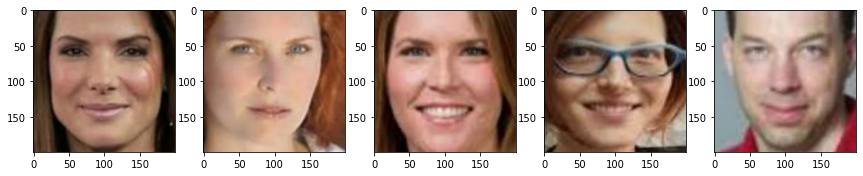

In [9]:
plt.figure(figsize=(30,30))

#looping over the images and selecting random images to view
for i in range(5):
    file = np.random.choice(os.listdir(UTKFace_folder))
    image_path= os.path.join(UTKFace_folder, file)
    image=mpimg.imread(image_path)
    plt.subplot(1,10,i+1)
    plt.imshow(image)

We will attempt the same procedure, but this time on a single image. We will look closely at just a single random image.

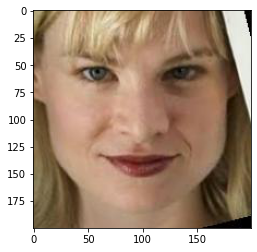

In [10]:
for i in range(1):
    file = np.random.choice(os.listdir(UTKFace_folder))
    image_path = os.path.join(UTKFace_folder, file)
    image=mpimg.imread(image_path)
    plt.imshow(image)

### Creating the Dataset

In this section, we will not attempt to organize and pre-process the data. It is also in this section that we will separate the images between male and female and remove any images with ages below 20 years old and above 60 years old.

The images as been pre-labled and we will be using Regex in retrieving image labels.

In [11]:
#creating a dataframe selecting gender and ages available
face_df = pd.DataFrame(glob.glob(os.path.join(UTKFace_folder, '*.jpg')), columns=['names'])
face_df['male'] = face_df.names.str.contains(r'\d+_0_[0-4]_\d+.jpg.chip.jpg$') + 0
face_df['age'] = face_df.names.str.extract(r'(\d+)_[0-1]_[0-4]_\d+.jpg.chip.jpg$').astype(int) 

#Limiting Age Group between 20-70
face_df = face_df[face_df['age'] <= 60] 
face_df = face_df[face_df['age'] >= 20] 

We will not view the images after the previous process. The purpose of this step is to verify that we are able to successfully separate the images accordingly.

__Gender:__

0 - Female

1 - Male

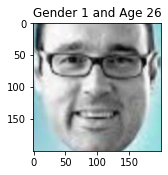

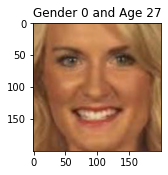

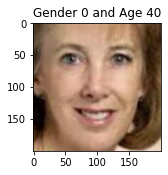

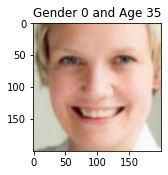

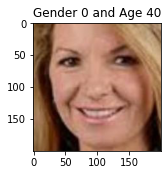

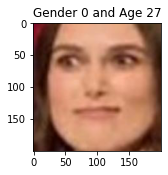

In [12]:
for idx, i in enumerate(face_df.sample(6).index):
  plt.figure(figsize=[8,8])
  im_row = face_df.loc[i,:]
  my_image = Image.open(im_row.names).convert('RGB')
  plt.subplot(3,2,idx+1)
  plt.imshow(my_image)
  plt.title(f'Gender {im_row.male} and Age {im_row.age}')

With the images properly separated, we will first separate the images into two dataframes. One for dataframe for Males and another for Females.

In [13]:
to_male = face_df[face_df['male'] == 1]
to_female = face_df[face_df['male'] == 0]

Once again we will verify that the dataframe assigned to the male gender is indeed pulling male images

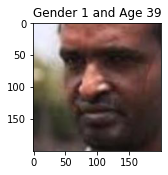

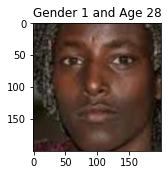

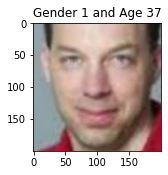

In [14]:
for idx, i in enumerate(to_male.sample(3).index):
  plt.figure(figsize=[8,8])
  im_row = face_df.loc[i,:]
  my_image = Image.open(im_row.names).convert('RGB')
  plt.subplot(3,2,idx+1)
  plt.imshow(my_image)
  plt.title(f'Gender {im_row.male} and Age {im_row.age}')

We will repeat the step, but this time retrieve images of Females. This is once again to verify that the dataset is indeed retreiving the correct images.

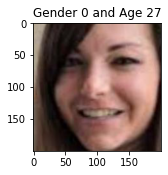

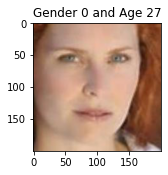

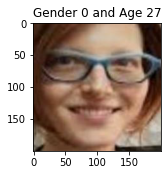

In [15]:
for idx, i in enumerate(to_female.sample(3).index):
  plt.figure(figsize=[8,8])
  im_row = face_df.loc[i,:]
  my_image = Image.open(im_row.names)
  plt.subplot(3,2,idx+1)
  plt.imshow(my_image)
  plt.title(f'Gender {im_row.male} and Age {im_row.age}')

We will now create global parameters which we can use at several points in this notebook. It will also be easier to remember number assigned.

### Resizing the images in the Dataset

In [16]:
all_im = glob(os.path.join(basepath, '**/*'))

TypeError: ignored

In [ ]:
# for im in tqdm(all_im):
#     image = Image.open(im)
#     image = image.resize((128,128), Image.BILINEAR)
#     image.save(im)

In [ ]:
all_im[-1]

##Parameters

In [98]:
#Creating the Parameters

parameters = {'ngf':32,
              'ndf':64,
              'num_epochs':100,
              'decay_epoch': 100,
              'lgG':0.0002,
              'lgD':0.0002,
              'beta1':.5,
              'beta2':.9999,
              'lambdaA':10,
              'lambdaB':10,
              'batch_size':20,
              'pool_size':50, 
              'img_width':256, 
              'img_height':256, 
              'img_depth':3,
              'input_size':128,
              'resize_size':286,
              'crop_size':256,
              'fliplr':True,
              'num_resnet':6,
              'num_workers':4
              }
          

## Creating functions

In the next set, we will create several functions that will be used throughout. The first function will convert our data into Numpy, which we can call at a later point.

We will also set a variable so we can use a GPU for faster processing.

In [99]:
#Convert to Numpy 
def to_numpy(x):
  return x.data.cpu().numpy()

#use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Transformer

Since we will be using a __transformer__ at a later stage, we will set a transformer variable and assign it procedures which transforms an image size accordingly. This transformer will also convert the image into a Tensor and Normalize it as well.

In [136]:
trans = transforms.Compose([
    #transforms.Resize(size=parameters['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

Defining a function which will __plot__ the result from training

In [137]:
def plot_train_result(real_image, gen_image, recon_image, epoch, save=False,  
                      show=True, fig_size=(15, 15)):
   
   fig, axes = plt.subplots(2, 3, figsize=fig_size)
   
   imgs = [to_numpy(real_image[0]), to_numpy(gen_image[0]), 
            to_numpy(recon_image[0]),
            to_numpy(real_image[1]), to_numpy(gen_image[1]), 
            to_numpy(recon_image[1])]
            
   for ax, img in zip(axes.flatten(), imgs):
     
     ax.axis('off')
     img = img.squeeze()
     img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)

     ax.imshow(img, cmap=None, aspect='equal')
    
   plt.subplots_adjust(wspace=0, hspace=0)

   title = 'Epoch {0}'.format(epoch + 1)
   fig.text(0.5, 0.04, title, ha='center')

Next, we will define an __ImagePool__ function

In [138]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        
        return_images = Variable(torch.cat(return_images, 0))
        
        return return_images

### Creating the Dataloader

In this section, we begin by creating the __dataloader__ which we will use to retrieve the data in parts.

In [139]:
class DatasetFromFolder(data.Dataset):
    
    def __init__(self, image_dir, subfolder='train', transform=None, 
                 resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = trans
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):

        # Load Images
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), 
                             Image.BILINEAR)

        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
        
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img = self.transform(img)

        return img   

### Creating the Convolutional Block

The __convolution__ block will consist of two things.

1. Initialization

2. Forward pass.

In [140]:
class ConvBlock(torch.nn.Module):
    
    #Initialize a dunction
    def __init__(self, input_size, output_size, kernel_size=3, stride=2,
                 padding=1, activation='relu', batch_norm=True):
        super(ConvBlock,self).__init__()
        
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size,
                                    stride, padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    
    #Defining the forward function
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out
  

### De-Convolution Function

In this class we will create, we will need to bring back the convolution from the results previously processed. There will be two functions inside this class.

1. Initialization

2. Forward pass

In [141]:
class DeconvBlock(torch.nn.Module):

    #Initialization Function
    def __init__(self, input_size, output_size, kernel_size=3, stride=2,
                 padding=1, output_padding=1, activation='relu',
                 batch_norm=True):
      
        super(DeconvBlock,self).__init__()

        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size,
                                               kernel_size, stride, padding,
                                               output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    
    #Forward pass
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out

### Residual Learning Block

In this secton, we will create a __residual learning__ block or __Resnet__. This class will also contain two functions.

1. Initialization

2. Forward pass

In [142]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()

        conv1 = torch.nn.Conv2d(num_filter, num_filter, kernel_size,
                                stride, padding)
        
        conv2 = torch.nn.Conv2d(num_filter, num_filter, kernel_size,
                                stride, padding)
        
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)
        
        self.resnet_block = torch.nn.Sequential(
            pad,
            conv1,
            bn,
            relu,
            pad,
            conv2,
            bn
            )
    def forward(self,x):
        out = self.resnet_block(x)
        return out

##Creating the Generator

We will now create the __Generator__. The Generator will consist of the following:
1. Encoder
2. Transformer
3. Decoder

In addition, we will also be adding __weights__.

After creating the class, we will create the actuall Generator.

In [143]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()
        
        #Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        
        #Encoder
        # Input Layer - NN Layer 1
        self.conv1 = ConvBlock(input_dim, num_filter, kernel_size=7, stride=1, 
                               padding=0)
        
        # NN Layer 2
        self.conv2 = ConvBlock(num_filter, num_filter*2)
        
        ## NN Layer 3
        self.conv3 = ConvBlock(num_filter*2, num_filter*4)
        
        #Transformer
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4, num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2, num_filter)
        self.deconv3 = ConvBlock(num_filter, output_dim, kernel_size=7,
                                 stride=1, padding=0, activation='tanh',
                                 batch_norm=False)
    
    #Forward Function
    def forward(self,x):
        
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        
        #Transformer
        res = self.resnet_blocks(enc3)
        
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    #Creating weights inside the Generator
    
    # def weights(m, mean=0.0, std = 0.02):
    #   for m in self.children():
    #     if isinstance(m, nn.Conv2d):
    #       nn.init.normal_(m.weight, 0.0, 0.02)
    #     elif isinstance(m, nn.BatchNorm2d):
    #       nn.init.normal_(m.weight, 0.0, 0.02)
    #       nn.init.constant_(m.bias, 0)
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)

### Creating the Generator and Testing the Neural Network

Since we will be using a Cycle GAN, which requires 2 Neural Networks competing with each other, we will create 2 Generators as its requirement.

#### Generator A

In [144]:
Generator_A = Generator(3, parameters['ngf'], 3, 
                        parameters['num_resnet']).cuda()
Generator_A.normal_weight_init(mean=0.0, std=0.02)
Generator_A

Generator(
  (pad): ReflectionPad2d((3, 3, 3, 3))
  (conv1): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (bn): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (resnet_blocks): Sequential(
    (0): ResnetB

#### Generator B

In [145]:
Generator_B = Generator(3, parameters['ngf'], 3, 
                        parameters['num_resnet']).cuda()
Generator_B.normal_weight_init(mean=0.0, std=0.02)
Generator_B

Generator(
  (pad): ReflectionPad2d((3, 3, 3, 3))
  (conv1): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (bn): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (resnet_blocks): Sequential(
    (0): ResnetB

##Creating the Discriminator

The Discriminator will consist of the following
1. Initialization
2. Forward Pass
3. Weights

After creating the class, we will create the actuall Discriminator.


In [146]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()

        #Input - NN Layer 1
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        
        #NN Layer 2
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        
        #NN Layer 3
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        
        #NN Layer 4
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        
        #Output - NN Layer 5
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        
        
        self.conv_blocks = torch.nn.Sequential(
            conv1,
            conv2,
            conv3,
            conv4,
            conv5
            )
        
    def forward(self,x):
        out = self.conv_blocks(x)
        return out

    #Creating the weights for the Discriminator
    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data, mean, std)


### Creating the Discriminator and Testing the Neural Network

Similar with the Generator, which requires 2 Neural Networks. We will create 2 Discriminators that compete with each other.

#### Discriminator A

In [147]:
Discriminator_A = Discriminator(3, parameters['ndf'], 1).cuda()
Discriminator_A.normal_weight_init(mean=0.0, std=0.02)
Discriminator_A


Discriminator(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    

#### Discriminator B

In [148]:
Discriminator_B = Discriminator(3, parameters['ndf'], 1).cuda()
Discriminator_B.normal_weight_init(mean=0.0, std=0.02)
Discriminator_B

Discriminator(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    

## Training Block / DataLoaders

In this block, we will create the actual training block we will be using to train our model.

In [149]:
train_data_A = DatasetFromFolder(basepath, subfolder='trainA_Male', transform=trans,
                                #resize_scale=parameters['resize_size'], 
                                #crop_size=parameters['crop_size'], 
                                #fliplr=parameters['fliplr']
                                 )

train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A, 
                                                  batch_size=parameters['batch_size'], 
                                                  num_workers=parameters['num_workers'],
                                                  pin_memory=True,
                                                  shuffle=True)

train_data_B = DatasetFromFolder(basepath, subfolder='trainB_Female', transform=trans,
                                 #resize_scale=parameters['resize_size'], 
                                 #crop_size=parameters['crop_size'], 
                                 #fliplr=True
                                 )

train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, 
                                                  batch_size=parameters['batch_size'], 
                                                  num_workers=parameters['num_workers'],
                                                  pin_memory=True,
                                                  shuffle=True)

#Load test data
test_data_A = DatasetFromFolder(basepath, subfolder='testA_Male', transform=trans)

test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, 
                                                 batch_size=parameters['batch_size'], 
                                                 shuffle=False)

test_data_B = DatasetFromFolder(basepath, subfolder='trainB_Female', transform=trans)

test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, 
                                                 batch_size=parameters['batch_size'], 
                                                 shuffle=False)


## Retreiving Items

In this block / section we will be retreiving an item for both the real data generated twice. We will also show this data not as an image, but as a Tensor array. We will do this to verify that there are some changes made compared to it's original state.

### Test Real Data A

In [150]:
test_real_A_data = train_data_A.__getitem__(11).unsqueeze(0)
test_real_A_data

tensor([[[[-0.0118, -0.0118, -0.0118,  ..., -0.0196,  0.1373,  0.2863],
          [-0.0118, -0.0039, -0.0039,  ...,  0.0118,  0.1059,  0.1765],
          [ 0.0039,  0.0039,  0.0039,  ...,  0.0980,  0.1137,  0.1059],
          ...,
          [ 0.3333,  0.3333,  0.3333,  ...,  0.5451,  0.5686,  0.5765],
          [ 0.3333,  0.3333,  0.3333,  ...,  0.5529,  0.5765,  0.5922],
          [ 0.3333,  0.3333,  0.3333,  ...,  0.5608,  0.5843,  0.6000]],

         [[-0.0039, -0.0039, -0.0039,  ..., -0.1922, -0.0353,  0.1137],
          [-0.0039,  0.0039,  0.0039,  ..., -0.1608, -0.0667,  0.0039],
          [ 0.0118,  0.0118,  0.0118,  ..., -0.0745, -0.0588, -0.0667],
          ...,
          [ 0.3412,  0.3412,  0.3412,  ...,  0.3333,  0.3569,  0.3647],
          [ 0.3412,  0.3412,  0.3412,  ...,  0.3412,  0.3647,  0.3804],
          [ 0.3412,  0.3412,  0.3412,  ...,  0.3490,  0.3725,  0.3882]],

         [[-0.0510, -0.0510, -0.0510,  ..., -0.5843, -0.4275, -0.2784],
          [-0.0510, -0.0431, -

### Test Real Data B

In [151]:
test_real_B_data = train_data_B.__getitem__(11).unsqueeze(0)
test_real_B_data

tensor([[[[ 0.0588,  0.1765,  0.2078,  ...,  0.1686,  0.3176,  0.4118],
          [ 0.1294,  0.2000,  0.1843,  ...,  0.1451,  0.2941,  0.3961],
          [ 0.2000,  0.2078,  0.1451,  ...,  0.1137,  0.2627,  0.3804],
          ...,
          [ 0.8353,  0.8431,  0.8431,  ...,  0.7804,  0.7804,  0.7804],
          [ 0.8510,  0.8510,  0.8510,  ...,  0.7804,  0.7804,  0.7804],
          [ 0.8588,  0.8667,  0.8588,  ...,  0.7804,  0.7804,  0.7804]],

         [[-0.1608, -0.0588, -0.0275,  ..., -0.0431,  0.1137,  0.2235],
          [-0.0902, -0.0353, -0.0510,  ..., -0.0667,  0.0902,  0.2078],
          [-0.0196, -0.0275, -0.0902,  ..., -0.0980,  0.0588,  0.1765],
          ...,
          [ 0.4745,  0.4824,  0.4902,  ...,  0.3176,  0.3098,  0.3098],
          [ 0.4902,  0.4902,  0.4980,  ...,  0.3098,  0.3098,  0.3098],
          [ 0.4980,  0.5059,  0.5059,  ...,  0.3098,  0.3098,  0.3098]],

         [[-0.2549, -0.1451, -0.1137,  ..., -0.2784, -0.1451, -0.0431],
          [-0.1843, -0.1216, -

## Creating the Optimizer

In [152]:
Generator_optimizer = torch.optim.Adam(itertools.chain(Generator_A.parameters(),
                                                       Generator_B.parameters()),
                                                       betas=(parameters['beta1'], parameters['beta2']),
                                                       lr=parameters['lgG'])

Discriminator_A_optimizer = torch.optim.Adam(itertools.chain(Discriminator_A.parameters(),
                                                           Discriminator_B.parameters()),
                                                           betas=(parameters['beta1'], parameters['beta2']),
                                                           lr=parameters['lgD'])

Discriminator_B_optimizer = torch.optim.Adam(itertools.chain(Discriminator_A.parameters(),
                                                           Discriminator_B.parameters()),
                                                           betas=(parameters['beta1'], parameters['beta2']),
                                                           lr=parameters['lgD'])


## Defining Losses

In [153]:
MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()

In [154]:
Discriminator_A_avg_losses = []
Discriminator_B_avg_losses = []
Generator_A_avg_losses = []
Generator_B_avg_losses = []

cycle_A_avg_losses = []
cycle_B_avg_losses = []

## Training the model and retreiving Images



Using the image pool created earliler, we will create a pool of variables which we will be using for training at the next cell block.

In [155]:
num_pool = 50
fake_A_Pool = ImagePool(num_pool)
fake_B_Pool = ImagePool(num_pool)

step = 0

We will now run the Training sequence in the block.

In [156]:

# for epoch in range(parameters['num_epochs']):
#     Discriminator_A_losses = []
#     Discriminator_B_losses = []
#     Generator_A_losses = []
#     Generator_B_losses = []
#     cycle_A_losses = []
#     cycle_B_losses = []
    
#     # Learing rate decay 
#     if(epoch + 1) > parameters['decay_epoch']:
#         Discriminatoroptimizer.param_groups[0]['lr'] -= parameters['lgD'] / (parameters['num_epochs'] - parameters['decay_epoch'])
#         Discriminator_B_optimizer.param_groups[0]['lr'] -= parameters['lgD'] / (parameters['num_epochs'] - parameters['decay_epoch'])
#         G_optimizer.param_groups[0]['lr'] -= parameters['lrG'] / (parameters['num_epochs'] - parameters['decay_epoch'])
        
    
#     # training 
#     for i, (real_A, real_B) in tqdm(enumerate(zip(train_data_loader_A, train_data_loader_B)), total=len(train_data_loader_A)):
        
#         # input image data
#         real_A = real_A.to(device)
#         real_B = real_B.to(device)
        
#         # Train The Generator
#         # A --> B
#         fake_B = Generator_A(real_A)
#         Discriminator_B_fake_decision = Discriminator_B(fake_B)
#         Generator_A_loss = MSE_Loss(Discriminator_B_fake_decision, Variable(torch.ones(Discriminator_B_fake_decision.size()).cuda()))
        
#         # Forward Cycle Loss
#         recon_A = Generator_B(fake_B)
#         cycle_A_loss = L1_Loss(recon_A, real_A) * parameters['lambdaA']
        
#         # B --> A
#         fake_A = Generator_B(real_B)
#         Discriminator_fake_decision = Discriminator_A(fake_A)
#         Generator_B_loss = MSE_Loss(Discriminator_fake_decision, Variable(torch.ones(Discriminator_fake_decision.size()).cuda()))
        
#         # Backward Cycle Loss
#         recon_B = Generator_A(fake_A)
#         cycle_B_loss = L1_Loss(recon_B, real_B) * parameters['lambdaB']
        
#         # Back Propagation
#         Generator_loss = Generator_A_loss + Generator_B_loss + cycle_A_loss + cycle_B_loss
#         Generator_optimizer.zero_grad()
#         Generator_loss.backward()
#         Generator_optimizer.step()
        
        
#         # Train Discriminator_A 
#         Discriminator_real_decision = Discriminator_A(real_A)
#         Discriminator_real_loss = MSE_Loss(Discriminator_real_decision, Variable(torch.ones(Discriminator_real_decision.size()).cuda()))
        
#         fake_A = fake_A_Pool.query(fake_A)
        
#         Discriminator_fake_decision = Discriminator_A(fake_A)
#         Discriminator_fake_loss = MSE_Loss(Discriminator_fake_decision, Variable(torch.zeros(Discriminator_fake_decision.size()).cuda()))
        
#         # Back propagation
#         Discriminator_A_loss = (Discriminator_real_loss + Discriminator_fake_loss) * 0.5
#         Discriminator_A_optimizer.zero_grad()
#         Discriminator_A_loss.backward()
#         Discriminator_A_optimizer.step()
        
#         # Train Discriminator_B 
#         Discriminator_B_real_decision = Discriminator_B(real_B)
        
#         try:
#           Discriminator_B_real_loss = MSE_Loss(Discriminator_B_real_decision, Variable(torch.ones(Discriminator_B_fake_decision.size()).cuda()))
#         except:
#           print(Discriminator_B_real_decision)

#         fake_B = fake_B_Pool.query(fake_B)
        
#         Discriminator_B_fake_decision = Discriminator_B(fake_B)
#         Discriminator_B_fake_loss = MSE_Loss(Discriminator_B_fake_decision, Variable(torch.zeros(Discriminator_B_fake_decision.size()).cuda()))
        
#         # Back Propagation
#         Discriminator_B_loss = (Discriminator_B_real_loss + Discriminator_B_fake_loss) * 0.5
#         Discriminator_B_optimizer.zero_grad()
#         #Discriminator_B_loss.backward()
#         Discriminator_B_optimizer.step()
        
#         #  Print 


#         # loss values
#         Discriminator_A_losses.append(Discriminator_A_loss.item())
#         Discriminator_B_losses.append(Discriminator_B_loss.item())
#         Generator_A_losses.append(Generator_A_loss.item())
#         Generator_B_losses.append(Generator_B_loss.item())
#         cycle_A_losses.append(cycle_A_loss.item())
#         cycle_B_losses.append(cycle_B_loss.item())

#         if i%100 == 0:
#             print('Epoch [%d/%d], Step [%d/%d], Discriminator_A_losses: %.4f, Discriminator_B_loss: %.4f, Generator_A_loss: %.4f, Generator_B_loss: %.4f'
#                   % (epoch+1, parameters['num_epochs'], i+1, len(train_data_loader_A), Discriminator_A_loss.item(), Discriminator_B_loss.item(), Generator_A_loss.item(), Generator_B_loss.item()))
            
#         step += 1
        
#     Discriminator_A_avg_loss = torch.mean(torch.FloatTensor(Discriminator_A_losses))
#     Discriminator_B_avg_loss = torch.mean(torch.FloatTensor(Discriminator_B_losses))
#     Generator_A_avg_loss = torch.mean(torch.FloatTensor(Generator_A_losses))
#     Generator_B_avg_loss = torch.mean(torch.FloatTensor(Generator_B_losses))
#     cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
#     cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

#     # Average Loss Values
#     Discriminator_A_avg_losses.append(Discriminator_A_avg_loss.item())
#     Discriminator_B_avg_losses.append(Discriminator_B_avg_loss.item())
#     Generator_A_avg_losses.append(Generator_A_avg_loss.item())
#     Generator_B_avg_losses.append(Generator_B_avg_loss.item())
#     cycle_A_avg_losses.append(cycle_A_avg_loss.item())
#     cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    
#     # Test Image Results
#     test_real_A = test_real_A_data.cuda()
#     test_fake_B = Generator_A(test_real_A)
#     test_recon_A = Generator_B(test_fake_B)

#     test_real_B = test_real_B_data.cuda()
#     test_fake_A = Generator_B(test_real_B)
#     test_recon_B = Generator_A(test_fake_A)

#     plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
#                             epoch, save=True)


In [157]:
scaler = torch.cuda.amp.GradScaler(enabled=True)
best_gen = np.inf

for epoch in range(parameters['num_epochs']):
    Discriminator_A_losses = []
    Discriminator_B_losses = []
    Generator_A_losses = []
    Generator_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    
    # Learing rate decay 
    if(epoch + 1) > parameters['decay_epoch']:
        Discriminatoroptimizer.param_groups[0]['lr'] -= parameters['lgD'] / (parameters['num_epochs'] - parameters['decay_epoch'])
        Discriminator_B_optimizer.param_groups[0]['lr'] -= parameters['lgD'] / (parameters['num_epochs'] - parameters['decay_epoch'])
        G_optimizer.param_groups[0]['lr'] -= parameters['lrG'] / (parameters['num_epochs'] - parameters['decay_epoch'])
        
    
    # training 
    for i, (real_A, real_B) in tqdm(enumerate(zip(train_data_loader_A, train_data_loader_B)), total=len(train_data_loader_A)):
        
        # input image data
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        # Train The Generator

        # A --> B
        fake_B = Generator_A(real_A)
        Discriminator_B_fake_decision = Discriminator_B(fake_B)
        Generator_A_loss = MSE_Loss(Discriminator_B_fake_decision, Variable(torch.ones(Discriminator_B_fake_decision.size()).cuda()))
        
        # Forward Cycle Loss
        recon_A = Generator_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * parameters['lambdaA']
        
        # B --> A
        fake_A = Generator_B(real_B)
        Discriminator_A_fake_decision = Discriminator_A(fake_A)
        Generator_B_loss = MSE_Loss(Discriminator_A_fake_decision, Variable(torch.ones(Discriminator_A_fake_decision.size()).cuda()))
        
        # Backward Cycle Loss
        recon_B = Generator_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * parameters['lambdaB']
        
        # Back Propagation
        Generator_loss = Generator_A_loss + Generator_B_loss + cycle_A_loss + cycle_B_loss
        Generator_optimizer.zero_grad()
        Generator_loss.backward(retain_graph=True)
        Generator_optimizer.step()
        
        
        # Train Discriminator_A 
        Discriminator_A_real_decision = Discriminator_A(real_A)
        Discriminator_A_real_loss = MSE_Loss(Discriminator_A_real_decision, Variable(torch.ones(Discriminator_A_real_decision.size()).cuda()))
        
        fake_A = fake_A_Pool.query(fake_A)
        
        Discriminator_A_fake_decision = Discriminator_A(fake_A)
        Discriminator_A_fake_loss = MSE_Loss(Discriminator_A_fake_decision, Variable(torch.zeros(Discriminator_A_fake_decision.size()).cuda()))
        
        # Back propagation
        Discriminator_A_loss = (Discriminator_A_real_loss + Discriminator_A_fake_loss) * 0.5
        Discriminator_A_optimizer.zero_grad()
        Discriminator_A_loss.backward(retain_graph=True)
        Discriminator_A_optimizer.step()
        
        # Train Discriminator_B 
        Discriminator_B_real_decision = Discriminator_B(real_B)
        Discriminator_B_real_loss = MSE_Loss(Discriminator_B_real_decision, Variable(torch.ones(Discriminator_B_fake_decision.size()).cuda()))
        
        # except:
        #   print(Discriminator_B_real_decision)

        fake_B = fake_B_Pool.query(fake_B)
        
        Discriminator_B_fake_decision = Discriminator_B(fake_B)
        Discriminator_B_fake_loss = MSE_Loss(Discriminator_B_fake_decision, Variable(torch.zeros(Discriminator_B_fake_decision.size()).cuda()))
        
        # Back Propagation
        Discriminator_B_loss = (Discriminator_B_real_loss + Discriminator_B_fake_loss) * 0.5
        Discriminator_B_optimizer.zero_grad()
        Discriminator_B_loss.backward()
        Discriminator_B_optimizer.step()
        
        #  Print 


        # loss values
        Discriminator_A_losses.append(Discriminator_A_loss.item())
        Discriminator_B_losses.append(Discriminator_B_loss.item())
        Generator_A_losses.append(Generator_A_loss.item())
        Generator_B_losses.append(Generator_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())

        if i%100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Discriminator_A_losses: %.4f, Discriminator_B_loss: %.4f, Generator_A_loss: %.4f, Generator_B_loss: %.4f'
                  % (epoch+1, parameters['num_epochs'], i+1, len(train_data_loader_A), Discriminator_A_loss.item(), Discriminator_B_loss.item(), Generator_A_loss.item(), Generator_B_loss.item()))
            
        step += 1
        
    Discriminator_A_avg_loss = torch.mean(torch.FloatTensor(Discriminator_A_losses))
    Discriminator_B_avg_loss = torch.mean(torch.FloatTensor(Discriminator_B_losses))
    Generator_A_avg_loss = torch.mean(torch.FloatTensor(Generator_A_losses))
    Generator_B_avg_loss = torch.mean(torch.FloatTensor(Generator_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # Average Loss Values
    Discriminator_A_avg_losses.append(Discriminator_A_avg_loss.item())
    Discriminator_B_avg_losses.append(Discriminator_B_avg_loss.item())
    Generator_A_avg_losses.append(Generator_A_avg_loss.item())
    Generator_B_avg_losses.append(Generator_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    
    # Test Image Results
    test_real_A = test_real_A_data.cuda()
    test_fake_B = Generator_A(test_real_A)
    test_recon_A = Generator_B(test_fake_B)

    test_real_B = test_real_B_data.cuda()
    test_fake_A = Generator_B(test_real_B)
    test_recon_B = Generator_A(test_fake_A)

    plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                            epoch, save=True)


RuntimeError: ignored

In [ ]:
""

In [ ]:
all_losses = pd.DataFrame()
all_losses['Discriminator_A_avg_losses'] = Discriminator_A_avg_losses
all_losses['Discriminator_B_avg_losses'] = Discriminator_B_avg_losses
all_losses['Generator_A_avg_losses'] = Generator_A_avg_losses
all_losses['Generator_B_avg_losses'] = Generator_B_avg_losses
all_losses['cycle_A_avg_losses'] = cycle_A_avg_losses
all_losses['cycle_B_avg_losses'] = cycle_B_avg_losses

print(all_losses)

In [ ]:
PATH = '/content/drive/My Drive/Thinkful/CapstoneIV'

In [ ]:
all_losses.to_csv(PATH, index=False)                                                                                                                                                                                          print(all_losses)

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
#PATH = '/content/drive/My Drive/Thinkful/CapstoneIV'

torch.save(Generator_A.state_dict(), PATH)
torch.save(Generator_B.state_dict(), PATH)
torch.save(Discrimninator_A.state_dict(), PATH)
torch.save(Discriminator_B.state_dict(), PATH)

IsADirectoryError: ignored

In [ ]:
torch.save( )